# ML Algorithm Application to fMRI data for Gender Classification

In [1]:
# Importing required libraries

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn import plotting 
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Let's keep our notebook clean, so it's a little more readable!

import warnings
warnings.filterwarnings('ignore')

In [3]:
# To view the plots inline with code

%matplotlib inline

# Data Exploration

In [4]:
# Lets fetch the data!

data = datasets.fetch_development_fmri()

In [5]:
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [6]:
# Lets explore data.func


print("Length of data.func", len(data.func))  ## Total Subjects
print("Type of data.func is:", type(data.func))
print("Value stored in data.func[0]",data.func[0]) ## data.func[0] is first element of data.func


Length of data.func 155
Type of data.func is: <class 'list'>
Value stored in data.func[0] /home/tjays/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [7]:
# Explore data.phenotypic

print("Type of data.phenotypic is:", type(data.phenotypic))
print("Value stored in data.phenotypic[0]",data.phenotypic[0]) 


Type of data.phenotypic is: <class 'numpy.ndarray'>
Value stored in data.phenotypic[0] ('sub-pixar123', 27.06, 'Adult', 'adult', 'F', 'R')


In [8]:
# Display Data Description

print("Description of dataset: ", data.description)

Description of dataset:  b"The movie watching based brain development dataset (fMRI)\r\n\r\n\r\nNotes\r\n-----\r\nThis functional MRI dataset is used for teaching how to use\r\nmachine learning to predict age from naturalistic stimuli (movie)\r\nwatching with Nilearn.\r\n\r\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\r\n18-39). This dataset can be used to try to predict who are adults and\r\nwho are children.\r\n\r\nThe data is downsampled to 4mm resolution for convenience. The original\r\ndata is downloaded from OpenNeuro.\r\n\r\nFor full information about pre-processing steps on raw-fMRI data, have a look\r\nat README at https://osf.io/wjtyq/\r\n\r\nFull pre-processed data: https://osf.io/5hju4/files/\r\n\r\nRaw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0\r\n\r\nContent\r\n-------\r\n    :'func': functional MRI Nifti images (4D) per subject\r\n    :'confounds': TSV file contain nuisance information per subject\r\n 

In [9]:
# Assign data.phenotypic to a variable; it will be used later for setting labels for classifier

pheno = data.phenotypic
print(pheno)

[('sub-pixar123', 27.06      , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar124', 33.44      , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar125', 31.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar126', 19.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar127', 23.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar128', 27.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar129', 23.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar130', 21.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar131', 39.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar132', 22.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar133', 21.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar134', 25.        , 'Adult', 'adult', 'M', 'R')
 ('sub-pixar135', 21.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar136', 25.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar137', 34.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar138', 28.        , 'Adult', 'adult', 'F', 'R')
 ('sub-pixar139', 18.        , 'Adult', 'adult', 'F', 'R

# Brain Parcellation for ROI Specification

In [10]:
#First, let's load a parcellation that we'd like to use

multiscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = multiscale.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /home/tjays/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


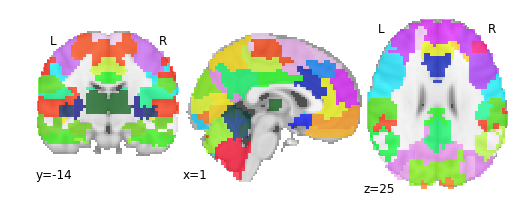

In [11]:
plotting.plot_roi(atlas_filename, draw_cross=False)

In [12]:
plotting.plot_roi

<function nilearn.plotting.img_plotting.plot_roi(roi_img, bg_img=<MNI152Template>, cut_coords=None, output_file=None, display_mode='ortho', figure=None, axes=None, title=None, annotate=True, draw_cross=True, black_bg='auto', threshold=0.5, alpha=0.7, cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f4a92f835d0>, dim='auto', vmin=None, vmax=None, resampling_interpolation='nearest', **kwargs)>

# Generating Time-series of Single Subject

In [13]:
# initialize the masker from which we will retrieve a 2D array
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

In [14]:
# example with one participant
sub = data.func[0]
conf = data.confounds[0]

# Extract brain signal while removing confounds
time_series = masker.fit_transform(sub, confounds=conf)

In [15]:
time_series.shape

(168, 64)

# Correlation Matrices

In [16]:
# initialize correlation measure, to build a "connectome"

# set to vectorize (ready for our predictive model later on!)
vectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)

# Just to visulalize single subect's correlation matrix
nonvectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True)

In [19]:
nonvectorized_correlation_matrix = nonvectorized_correlation_measure.fit_transform([time_series])[0]
vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
print('Nonvectorized Correlation Matrix.shape: {}'.format(nonvectorized_correlation_matrix.shape))
print('vectorized_correlation_matrix.shape: {}'.format(vectorized_correlation_matrix.shape))

Nonvectorized Correlation Matrix.shape: (64, 64)
vectorized_correlation_matrix.shape: (2016,)


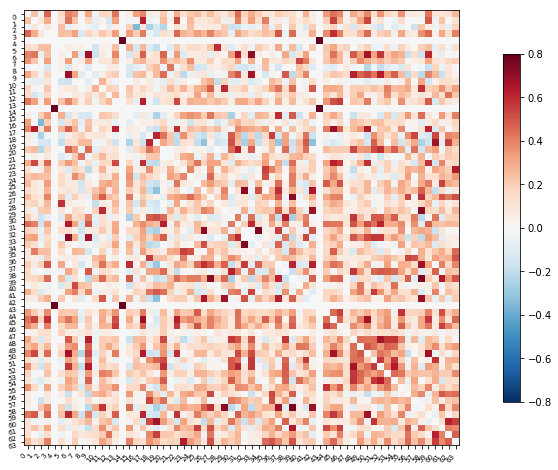

In [20]:
# Mask the main diagonal for visualization:
np.fill_diagonal(nonvectorized_correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label  
plotting.plot_matrix(nonvectorized_correlation_matrix, figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

# matrices are ordered for block-like representation

# Features Dataframe for Machine Learning 

In [31]:
from tqdm import tqdm

In [58]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(tqdm(data.func)):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    # create a region x region correlation matrix
    vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(vectorized_correlation_matrix)
    

100%|██████████| 155/155 [04:41<00:00,  1.81s/it]


In [ ]:
print(type(all_features))


In [ ]:
# Let's save the data to disk
np.savez_compressed(os.path.join(os.curdir, 'MAIN_BASC064_subsamp_features'),a = all_features)

In [17]:
# Making features data frame from stored features file

feat_file = os.path.join(os.curdir, 'MAIN_BASC064_subsamp_features.npz')
df_features = pd.DataFrame(np.load(feat_file)['a'])

In [18]:
# Converting all_features from list to pandas dataframe
#df_features = pd.DataFrame(all_features)

print(df_features.shape)
df_features.head()

(155, 2016)


,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.377468,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.072512,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.516681,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,-0.070190,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.278559,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354


Text(0,0.5,'subject')

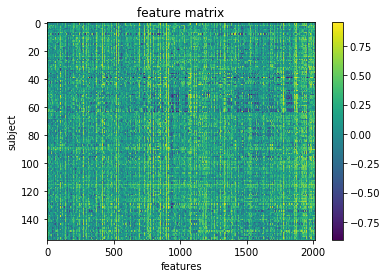

In [19]:
plt.imshow(df_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subject')

In [21]:
df_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.438603,0.115481,0.138229,0.495525,0.325086,0.139913,0.035265,0.049362,0.043459,0.066615,...,0.318569,0.277929,0.157189,0.431242,0.368352,0.484600,0.112711,0.281814,0.249751,0.400408
std,0.136199,0.139860,0.150602,0.138108,0.139446,0.142665,0.129211,0.143999,0.132486,0.152607,...,0.232029,0.212595,0.203954,0.182167,0.186938,0.174347,0.221107,0.221537,0.201770,0.177003
min,-0.040300,-0.259276,-0.386562,0.060856,-0.076095,-0.190003,-0.255162,-0.353081,-0.287570,-0.274818,...,-0.714710,-0.309452,-0.402019,-0.249006,-0.093113,-0.098144,-0.744601,-0.684216,-0.376467,-0.135318
25%,0.363638,0.026928,0.043248,0.417529,0.249166,0.039026,-0.034033,-0.025750,-0.041741,-0.009376,...,0.182286,0.138482,0.015483,0.319277,0.255541,0.386803,-0.010240,0.156909,0.102142,0.305254
50%,0.454781,0.117421,0.134308,0.509799,0.345709,0.148410,0.000082,0.014644,0.011904,0.024636,...,0.361410,0.276618,0.165106,0.465682,0.394346,0.514011,0.132403,0.305244,0.265340,0.424061
75%,0.532945,0.218490,0.245897,0.596292,0.415149,0.233340,0.116784,0.124545,0.113476,0.149484,...,0.468882,0.418125,0.307049,0.564425,0.482785,0.596482,0.269939,0.449185,0.392385,0.523710
max,0.726722,0.536872,0.565612,0.777401,0.607736,0.544285,0.450133,0.465348,0.430848,0.515875,...,0.769479,0.742385,0.659952,0.818867,0.855198,0.814587,0.601870,0.709806,0.783219,0.749233


# Target (Labels) DataFrame for Machine Learning

In [52]:
from sklearn import preprocessing


In [53]:
# Convert pheno to pandas DataFrame

pheno = pd.DataFrame(pheno)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [54]:
# Extract Gender Column to another DataFrame df_labels

df_labels = pd.DataFrame(pheno['Gender'])
df_labels

,Gender
0,F
1,M
2,M
3,F
4,F
...,...
150,F
151,F
152,F
153,F


In [55]:
# Convert Categorical Variable "Gender" to numeric 

le = preprocessing.LabelEncoder()
le.fit(df_labels.values)
print(le.classes_)
df_labels = pd.DataFrame(data=le.transform(df_labels.values),columns=['Gender'])
df_labels.head()

['F' 'M']


,Gender
0,0
1,1
2,1
3,0
4,0


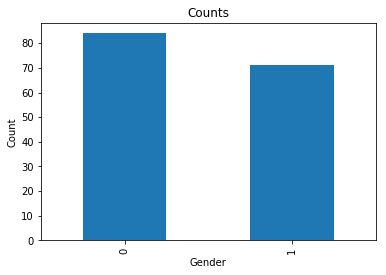

In [28]:
# Plot a Bar Chart depicting the count of each unique value in Gender column

df_labels['Gender'].value_counts().plot(kind='bar',title='Counts')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [29]:
# Total Count of each unique value of Gender

df_labels['Gender'].value_counts()

0    84
1    71
Name: Gender, dtype: int64

In [35]:
# A combined data frame with all the features and labels columns

df_combined = pd.concat([df_features,df_labels],axis=1, sort=False)
print(df_combined.shape)
print(type(df_combined))
df_combined.head()


(155, 2017)
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Gender
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202,0
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578,1
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499,1
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537,0
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354,0


In [44]:
df_combined.dtypes

0         float64
1         float64
2         float64
3         float64
4         float64
           ...   
2012      float64
2013      float64
2014      float64
2015      float64
Gender      int64
Length: 2017, dtype: object

In [36]:
df_combined.Gender.unique()

array([0, 1])

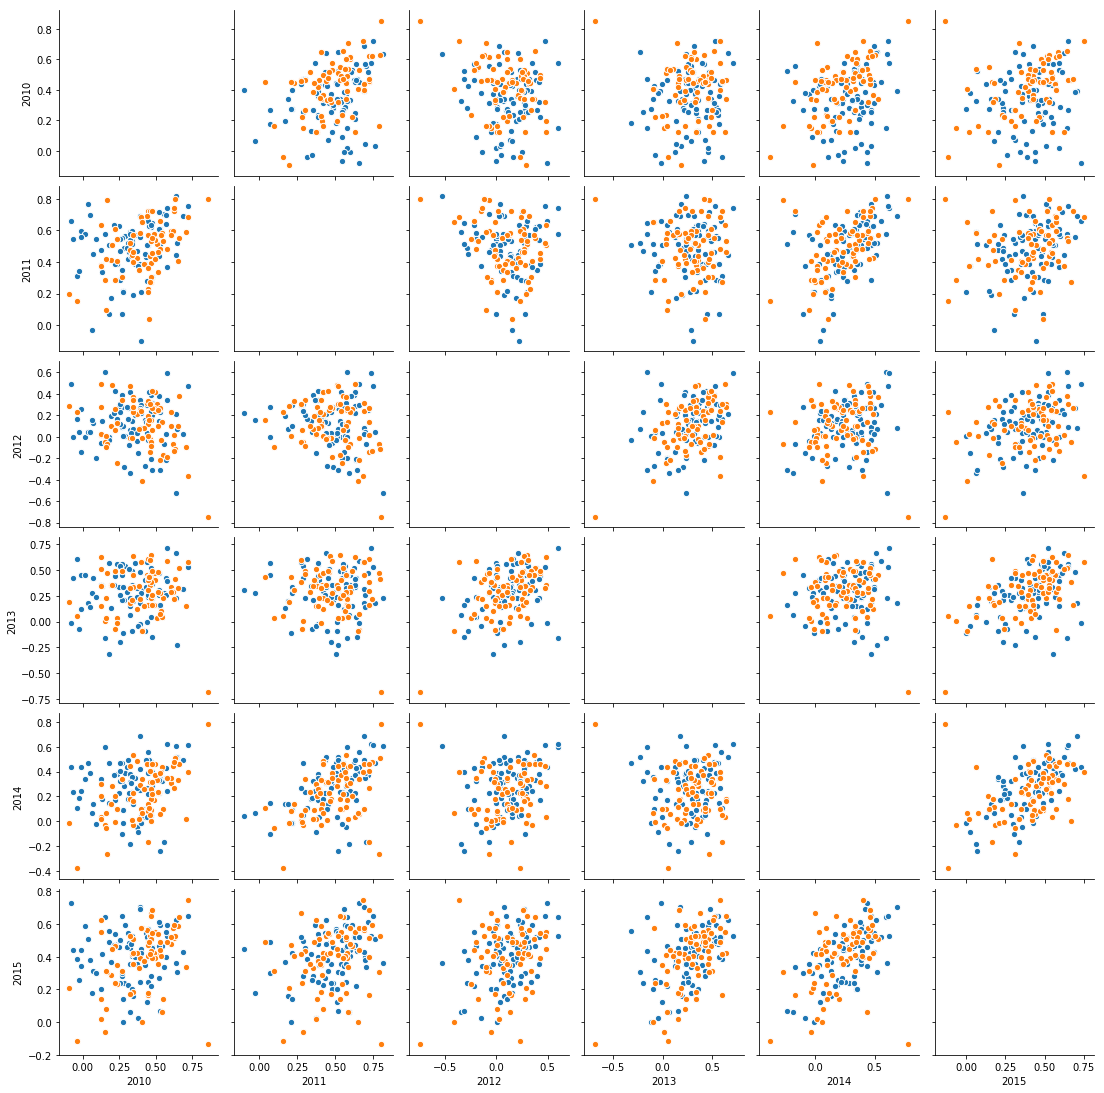

In [37]:
# Grid Plot or matrix plot
g = sns.PairGrid(df_combined.iloc[:,2010:2017], hue="Gender")
#g = g.map_diag(plt.hist, edgecolor="w") # histogram on diagonals
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40) #off diagonals will be scatter plots; s=40 telling the size of grid
plt.show()

# Data Preprocessing

In [43]:
from sklearn.preprocessing import StandardScaler

In [45]:
Scaler = StandardScaler()
Scaler.fit(df_features)
scaled_features = Scaler.transform(df_features)
df_scaled = pd.DataFrame(scaled_features)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,-1.515497,-1.141296,-0.307894,-0.215941,-0.214720,-0.341504,-0.273596,-0.344031,-0.328965,-0.438011,...,0.254664,-0.672973,0.282347,0.100029,-0.732076,-0.560175,0.242973,1.222142,0.641071,0.423924
1,0.210981,-1.685259,-1.337474,-0.168522,0.366557,-0.736920,-0.272097,-0.343636,-0.330542,-0.436474,...,-1.063896,-0.026879,-0.934951,-0.217158,-0.728229,0.365252,-1.611598,-1.131078,-0.767094,-0.962584
2,0.073609,0.111199,1.188031,1.213449,-0.377012,-0.291854,-0.453692,-0.830873,0.171116,-0.275971,...,0.856592,1.654712,1.220617,0.884819,1.546914,0.400333,1.197804,1.045730,1.031915,1.360816
3,-1.488341,-0.483799,-0.905920,-0.340445,-1.312967,-0.503181,-0.688573,-0.551407,-0.217067,-0.200541,...,-1.680907,1.194166,-0.416066,-1.405933,-0.930725,-1.806623,0.358641,-0.664579,-0.566354,-0.180646
4,-1.433392,-0.232046,1.358739,-1.117597,-2.886296,-1.590169,0.776734,-1.094063,-0.425675,0.666637,...,-0.172995,-0.874590,0.550453,-0.097990,-1.286100,-0.839696,0.150031,0.289781,-0.361241,0.107382


In [46]:
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,...,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02,1.550000e+02
mean,1.994104e-15,2.578583e-16,-1.031433e-16,3.105759e-15,-5.157165e-16,3.724619e-16,1.489848e-16,-1.833659e-16,1.031433e-16,-2.750488e-16,...,-7.563842e-16,-3.438110e-17,2.635884e-16,2.005564e-15,-2.292073e-16,-2.607233e-16,1.489848e-16,1.833659e-16,-2.177470e-16,-1.913881e-15
std,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,...,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00,1.003241e+00
min,-3.527588e+00,-2.688202e+00,-3.495905e+00,-3.157499e+00,-2.886296e+00,-2.320025e+00,-2.254985e+00,-2.803813e+00,-2.506707e+00,-2.244592e+00,...,-4.467665e+00,-2.771870e+00,-2.750717e+00,-3.746301e+00,-2.476540e+00,-3.353268e+00,-3.889938e+00,-4.374707e+00,-3.113684e+00,-3.036454e+00
25%,-5.521948e-01,-6.352047e-01,-6.327128e-01,-5.665749e-01,-5.462079e-01,-7.094570e-01,-5.380529e-01,-5.233007e-01,-6.451750e-01,-4.995696e-01,...,-5.892581e-01,-6.580564e-01,-6.970443e-01,-6.166185e-01,-6.054215e-01,-5.627503e-01,-5.578738e-01,-5.656400e-01,-7.339434e-01,-5.393242e-01
50%,1.191613e-01,1.391431e-02,-2.612017e-02,1.036913e-01,1.483684e-01,5.975025e-02,-2.731738e-01,-2.418783e-01,-2.389513e-01,-2.759711e-01,...,1.852363e-01,-6.186771e-03,3.894675e-02,1.896717e-01,1.395038e-01,1.692436e-01,8.935133e-02,1.061043e-01,7.750931e-02,1.340625e-01
75%,6.949186e-01,7.389027e-01,7.172353e-01,7.319878e-01,6.479550e-01,6.569876e-01,6.329402e-01,5.238013e-01,5.302013e-01,5.447827e-01,...,6.499196e-01,6.615887e-01,7.371537e-01,7.334778e-01,6.141284e-01,6.438019e-01,7.134020e-01,7.579480e-01,7.092041e-01,6.988627e-01
max,2.122276e+00,3.022718e+00,2.847024e+00,2.047594e+00,2.033518e+00,2.843606e+00,3.221189e+00,2.898171e+00,2.933489e+00,2.953452e+00,...,1.949635e+00,2.191780e+00,2.473070e+00,2.134755e+00,2.612755e+00,1.898839e+00,2.219493e+00,1.938179e+00,2.652511e+00,1.977110e+00


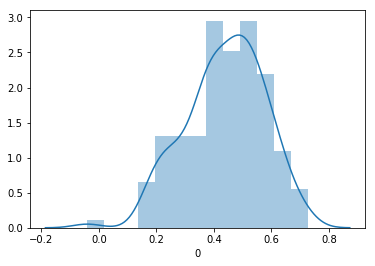

In [47]:
sns.distplot(df_features[0])

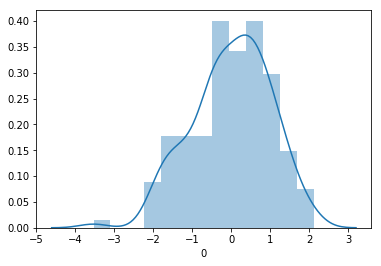

In [48]:
sns.distplot(df_scaled[0])

# Train/Test Set for ML

In [50]:
from sklearn.model_selection import train_test_split

In [104]:
# Split the sample to training/validation with a 70/30 ratio, and 
# stratify by df_labels, and also shuffle the data.

X_train, X_val, y_train, y_val = train_test_split(
                                                    df_features, # x
                                                    df_labels.values, # y
                                                    test_size = 0.30, # 70%/30% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = df_labels.values,  # keep
                                                                           # distribution
                                                                           # of Gender
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train), 'testing:', len(X_val))

training: 108 testing: 47


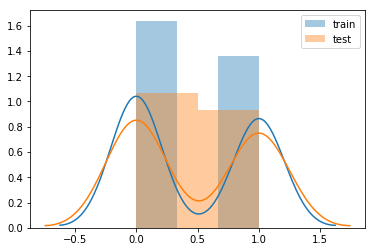

In [40]:
# Plotting distribution of y_train and y_test samples

sns.distplot(y_train,label='train')
sns.distplot(y_val,label='test')
plt.legend()

# Train/Test with Scaled Data

In [56]:
# Split the sample to training/validation with a 70/30 ratio, and 
# stratify by df_labels, and also shuffle the data.

X_train_sca, X_val_sca, y_train_sca, y_val_sca = train_test_split(
                                                    df_scaled, # x
                                                    df_labels.values, # y
                                                    test_size = 0.30, # 70%/30% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = df_labels.values,  # keep
                                                                           # distribution
                                                                           # of Gender
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train_sca), 'testing:', len(X_val_sca))

training: 108 testing: 47


# Classification Models

## Logistic Regression with leave-one-out Cross Validation

In [49]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [138]:
# CV with Leave-One-Out

loo = LeaveOneOut() # for leaveOneOut cross validation

clf_lg = LogisticRegression(random_state=0) 
# predict
y_pred = cross_val_predict(clf_lg, X_train, y_train, cv=loo)

acc = cross_val_score(clf_lg , X = X_train , y = y_train , cv = loo, scoring='accuracy') # Cross validation scores
mae = cross_val_score(clf_lg, X_train, y_train, cv=loo, scoring='neg_mean_absolute_error')

In [143]:
type(y_pred)

numpy.ndarray

In [142]:
y_pred.shape

(108,)

In [57]:
# CV with Leave-One-Out With Scaled Data

loo = LeaveOneOut() # for leaveOneOut cross validation

clf_lg = LogisticRegression(random_state=0) 
# predict
y_pred = cross_val_predict(clf_lg, X_train_sca, y_train_sca, cv=loo)

acc = cross_val_score(clf_lg , X = X_train_sca , y = y_train_sca , cv = loo, scoring='accuracy') # Cross validation scores
mae = cross_val_score(clf_lg, X_train_sca, y_train_sca, cv=loo, scoring='neg_mean_absolute_error')

In [82]:
def conf_matrix(test_Y, prediction):
    con_matrix = confusion_matrix(test_Y,prediction)
    print('Confusion_matrix', con_matrix)
    plt.figure()
    plt.matshow(con_matrix,cmap='Pastel1')
    for x in range(0, 2):
        for y in range(0,2):
            plt.text(x,y,con_matrix[x, y])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print('True Negative = ',con_matrix[0][0])
    print('False Negative = ',con_matrix[0][1])
    print('False Positive = ',con_matrix[1][0])
    print('True Positive = ',con_matrix[1][1])

In [58]:
print(acc.mean() * 100)
print(mae.mean() * 100)

61.111111111111114
-38.88888888888889


In [71]:
# CV with 10-folds

# predict
y_pred = cross_val_predict(clf_lg, X_train, y_train, cv=10)
# scores
acc = cross_val_score(clf_lg, X_train, y_train, cv=10)
mae = cross_val_score(clf_lg, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
clf_lg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
print(acc.mean() * 100)
print(mae.mean() * 100)

60.54545454545455
-39.45454545454545


In [73]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64        59
           1       0.56      0.55      0.56        49

    accuracy                           0.60       108
   macro avg       0.60      0.60      0.60       108
weighted avg       0.60      0.60      0.60       108



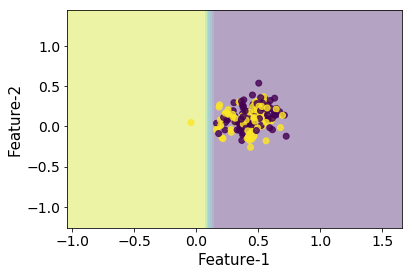

In [84]:
try:
    X = np.array(df_features)
    y = np.array(df_labels).flatten()
except:
    print("Coercing input data to NumPy arrays failed")
# Reduces to the first two columns of data
reduced_data = X[:, 2014:2016]

model = clf_lg
# Fits the model with the reduced data
model.fit(reduced_data, y)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.xlabel("Feature-1",fontsize=15)
plt.ylabel("Feature-2",fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## K-Nearest Neighbors Classifier

In [48]:
clf_knn = KNeighborsClassifier(n_neighbors = 3, metric ='manhattan',p=1)

In [49]:
# predict
y_pred = cross_val_predict(clf_knn, X_train, y_train, cv=10)

# scores
acc = cross_val_score(clf_knn, X_train, y_train, cv=10)
mae = cross_val_score(clf_knn, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [50]:
print(acc.mean())
print(mae.mean())

0.5009090909090909
-0.49909090909090914


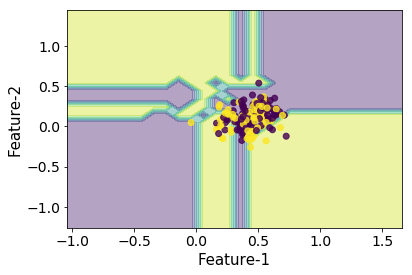

In [85]:
try:
    X = np.array(df_features)
    y = np.array(df_labels).flatten()
except:
    print("Coercing input data to NumPy arrays failed")
# Reduces to the first two columns of data
reduced_data = X[:, 2014:2016]

model = clf_knn
# Fits the model with the reduced data
model.fit(reduced_data, y)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.xlabel("Feature-1",fontsize=15)
plt.ylabel("Feature-2",fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## MLP Classifier

In [52]:
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [53]:
# predict
y_pred = cross_val_predict(clf_mlp, X_train, y_train, cv=10)

# scores
acc = cross_val_score(clf_mlp, X_train, y_train, cv=10)
mae = cross_val_score(clf_mlp, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [54]:
print(acc.mean())
print(mae.mean())

0.5463636363636363
-0.4536363636363636


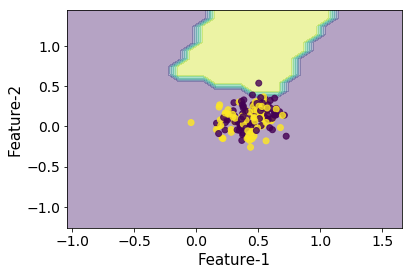

In [87]:
try:
    X = np.array(df_features)
    y = np.array(df_labels).flatten()
except:
    print("Coercing input data to NumPy arrays failed")
# Reduces to the first two columns of data
reduced_data = X[:, 2000:2002]

model = clf_mlp
# Fits the model with the reduced data
model.fit(reduced_data, y)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.xlabel("Feature-1",fontsize=15)
plt.ylabel("Feature-2",fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Dimensionality Reduction

## PCA

In [60]:
from sklearn.decomposition import PCA

In [64]:
pca = PCA(.95)
pca.fit(df_scaled)
x_pca = pca.transform(df_scaled)
print(x_pca.shape)

(155, 113)


In [65]:
print(x_pca)

[[  1.62722337  -8.65471248  -5.82372379 ...  -2.64229288  -0.77695274
   -2.64289042]
 [-16.42935294   4.83335066  -0.60618936 ...  -1.93503094  -1.72502644
    1.14099445]
 [ 29.89672916   2.95743615  -3.22880558 ...  -2.49343341  -0.47515221
   -2.92188186]
 ...
 [ -9.80305851  -2.92252404  -4.25671463 ...   1.21965806   3.9836029
    0.62518208]
 [ -5.06019341  13.39165955   3.90493085 ...   0.45488761   1.30915201
   -0.07570307]
 [ -0.84709655   2.12666092 -18.02233496 ...   0.351688    -0.26711487
    0.47906173]]


In [66]:
print(pca.n_components_)

113


Text(0,0.5,'Second Principal Component')

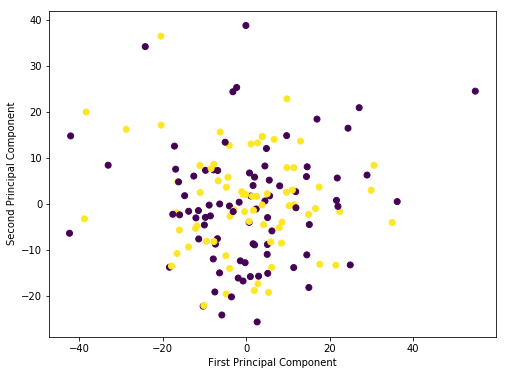

In [67]:

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c = df_labels['Gender'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [73]:
# Split the sample to training/validation with a 70/30 ratio, and 
# stratify by df_labels, and also shuffle the data.

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
                                                    x_pca, # x
                                                    df_labels.values, # y
                                                    test_size = 0.30, # 70%/30% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = df_labels.values,  # keep
                                                                           # distribution
                                                                           # of Gender
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train_pca), 'testing:', len(X_val_pca))

training: 108 testing: 47


In [74]:


# CV with 10-folds

# predict
y_pred_pca = cross_val_predict(clf_lg, X_train_pca, y_train_pca, cv=10)
# scores
acc = cross_val_score(clf_lg, X_train_pca, y_train_pca, cv=10)
mae = cross_val_score(clf_lg, X_train_pca, y_train_pca, cv=10, scoring='neg_mean_absolute_error')
clf_lg.fit(X_train_pca,y_train_pca)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
print(acc.mean() * 100)
print(mae.mean() * 100)

52.18181818181817
-47.81818181818182


In [77]:
print(classification_report(y_train_pca, y_pred_pca))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57        59
           1       0.47      0.45      0.46        49

    accuracy                           0.52       108
   macro avg       0.51      0.51      0.51       108
weighted avg       0.52      0.52      0.52       108



Confusion_matrix [[34 25]
 [27 22]]


<Figure size 432x288 with 0 Axes>

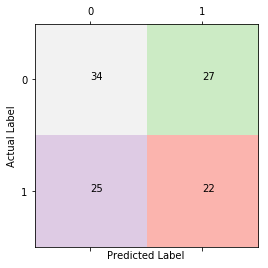

True Negative =  34
False Negative =  25
False Positive =  27
True Positive =  22


In [83]:

conf_matrix(y_train_pca,y_pred_pca)

# PLS

In [101]:
from sklearn.cross_decomposition import PLSRegression


Text(0.5,1,'Gender')

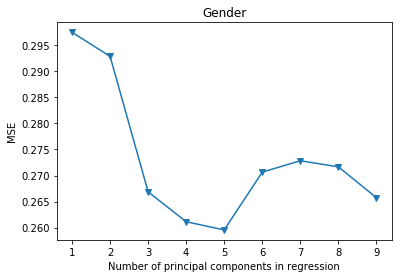

In [121]:
mse = [] 

for i in np.arange(1, 10):
    clf_pls = PLSRegression(n_components=i, scale = False)
    score = cross_val_score(clf_pls, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean()
    mse.append(-score)
    # Plot results
plt.plot(np.arange(1, 10), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Gender')

    

In [152]:
clf_pls = PLSRegression(n_components = 5)
# scores
mse = cross_val_score(clf_pls, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(acc.mean() * 100)
print(mse.mean() * 100)
y_pred = cross_val_predict(clf_pls, X_train, y_train, cv = 10)

-30.465787549726862
-26.303974629542402


In [153]:
y_pred

array([[ 0.08373782],
       [ 0.55213054],
       [-0.04683844],
       [ 0.42300447],
       [ 0.23843716],
       [ 0.54987456],
       [ 0.79354928],
       [ 0.16131471],
       [ 1.01524438],
       [ 0.4969919 ],
       [ 0.14149006],
       [ 0.70959436],
       [ 0.55273937],
       [ 0.66208794],
       [ 0.17538116],
       [ 0.55840736],
       [ 0.32344384],
       [ 0.37063067],
       [ 0.74298285],
       [ 0.67535204],
       [ 1.07532517],
       [ 0.04496117],
       [ 0.66905573],
       [ 0.54186589],
       [ 0.89567497],
       [ 0.36136558],
       [ 0.57158969],
       [ 0.01282761],
       [ 0.13293324],
       [ 0.41996202],
       [ 0.94122281],
       [ 0.47447351],
       [ 0.41794486],
       [ 0.52834222],
       [ 0.85389412],
       [ 0.15296366],
       [ 0.45195171],
       [ 0.35487988],
       [ 0.03413739],
       [ 0.09191153],
       [ 0.09912152],
       [ 0.85918015],
       [ 0.66002403],
       [ 0.37176505],
       [ 0.81849485],
       [ 0

In [154]:
y_pred.shape

(108, 1)

In [155]:
y_pred = y_pred.reshape(108,)

In [156]:
y_pred

array([ 0.08373782,  0.55213054, -0.04683844,  0.42300447,  0.23843716,
        0.54987456,  0.79354928,  0.16131471,  1.01524438,  0.4969919 ,
        0.14149006,  0.70959436,  0.55273937,  0.66208794,  0.17538116,
        0.55840736,  0.32344384,  0.37063067,  0.74298285,  0.67535204,
        1.07532517,  0.04496117,  0.66905573,  0.54186589,  0.89567497,
        0.36136558,  0.57158969,  0.01282761,  0.13293324,  0.41996202,
        0.94122281,  0.47447351,  0.41794486,  0.52834222,  0.85389412,
        0.15296366,  0.45195171,  0.35487988,  0.03413739,  0.09191153,
        0.09912152,  0.85918015,  0.66002403,  0.37176505,  0.81849485,
        0.41335435,  0.57534095,  0.57944177,  0.54118612,  0.58356876,
        0.90875392,  0.87487254,  0.64537384,  0.20592307,  0.22345362,
        0.48575422,  0.59452953,  0.53745097,  0.6758177 ,  0.7541573 ,
        1.15714268,  0.86394531,  0.67739151,  0.13839262,  0.24561267,
        1.02027959,  0.16775941,  0.22536906,  0.40152765,  0.47

In [157]:
y_pred = y_pred > 0.5
y_pred

array([False,  True, False, False, False,  True,  True, False,  True,
       False, False,  True,  True,  True, False,  True, False, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True, False, False, False, False, False, False,  True,
        True, False,  True, False, False,  True, False, False, False])

In [158]:
np.multiply(y_pred,1)

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [162]:
from sklearn.metrics import accuracy_score


print(accuracy_score(y_train,y_pred)*100)

59.25925925925925


Confusion_matrix [[37 22]
 [22 27]]


<Figure size 432x288 with 0 Axes>

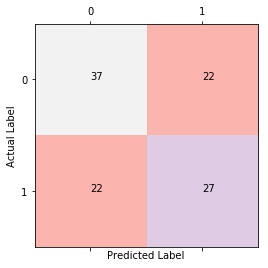

True Negative =  37
False Negative =  22
False Positive =  22
True Positive =  27


In [159]:
conf_matrix(y_train, y_pred)